In [1]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Add project directory to path
import os
import sys
sys.path.append(os.path.abspath(".."))


In [2]:
# Import custom modules
from src.data.data_ingestion import DataIngestion,DataIngestionConfig
from src.data.data_preprocessing import DataPreprocessing
from src.analysis.correlation_analysis import CorrelationAnalysis
from src.analysis.cointegration_tests import CointegrationTests, CointegrationTestsConfig
from src.utils.logger import get_logger

In [3]:
# Initialize logger
logger = get_logger("cointegration_tests_notebook")
logger.info("Starting cointegration tests for pairs")

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Load processed data
logger.info("Loading processed data")

[ 2025-05-11 19:55:47,588 ] 3 cointegration_tests_notebook - INFO - Starting cointegration tests for pairs
[ 2025-05-11 19:55:47,591 ] 10 cointegration_tests_notebook - INFO - Loading processed data


In [4]:
custom_config = DataIngestionConfig()
# Fix the path - go up one level from notebooks directory
custom_config.project_root = os.path.dirname(os.getcwd())  
custom_config.raw_data_path = os.path.join(custom_config.project_root, 'data', 'raw', 'Portfolio_prices.csv')
custom_config.processed_data_dir = os.path.join(custom_config.project_root, 'data', 'processed')

# Use the existing DataIngestion class with our fixed config
data_ingestion = DataIngestion(config=custom_config)
raw_df = data_ingestion.read_data()

print(f"Dataset shape: {raw_df.shape}")
raw_df.head()

[ 2025-05-11 19:56:15,842 ] 47 src.data.data_ingestion - INFO - Raw data path: d:\projects\Relative-Value-Analysis-Pairs-Trading\data\raw\Portfolio_prices.csv
[ 2025-05-11 19:56:15,843 ] 48 src.data.data_ingestion - INFO - File exists: True
[ 2025-05-11 19:56:15,844 ] 61 src.data.data_ingestion - INFO - Started reading data from d:\projects\Relative-Value-Analysis-Pairs-Trading\data\raw\Portfolio_prices.csv
[ 2025-05-11 19:56:15,910 ] 76 src.data.data_ingestion - INFO - Successfully read data with shape: (35397, 9)


Dataset shape: (35397, 9)


,Date,Ticker,Open,High,Low,Close,Adjusted,Returns,Volume
0,2020-01-03,JPM,137.500000,139.229996,137.080002,138.339996,119.874138,-0.013197,10386800
1,2020-01-03,KO,54.320000,54.990002,54.090000,54.689999,46.494698,-0.005455,11354500
2,2020-01-03,LMT,404.019989,417.170013,403.000000,413.739990,359.312317,0.035981,2990100
3,2020-01-03,MS,51.220001,51.450001,50.830002,51.200001,43.273079,-0.016142,6706000
4,2020-01-03,MSCI,262.200012,263.579987,259.269989,260.750000,248.019470,-0.019921,459700


In [5]:
data_preprocessor = DataPreprocessing()


In [6]:
# Read and preprocess the data
raw_df = data_ingestion.read_data()
processed_df = data_preprocessor.preprocess_data(raw_df)
logger.info(f"Processed data shape: {processed_df.shape}")


[ 2025-05-11 19:56:28,437 ] 61 src.data.data_ingestion - INFO - Started reading data from d:\projects\Relative-Value-Analysis-Pairs-Trading\data\raw\Portfolio_prices.csv
[ 2025-05-11 19:56:28,493 ] 76 src.data.data_ingestion - INFO - Successfully read data with shape: (35397, 9)
[ 2025-05-11 19:56:28,494 ] 185 src.data.data_preprocessing - INFO - Starting data preprocessing
[ 2025-05-11 19:56:28,494 ] 82 src.data.data_preprocessing - INFO - Converting Date to datetime format
[ 2025-05-11 19:56:28,503 ] 87 src.data.data_preprocessing - INFO - Successfully converted Date to datetime format
[ 2025-05-11 19:56:28,504 ] 108 src.data.data_preprocessing - INFO - Handling missing values
[ 2025-05-11 19:56:28,508 ] 112 src.data.data_preprocessing - INFO - Missing values before handling: Date        0
Ticker      0
Open        0
High        0
Low         0
Close       0
Adjusted    0
Returns     0
Volume      0
dtype: int64
d:\projects\Relative-Value-Analysis-Pairs-Trading\src\data\data_preproce

In [7]:
# Path to correlated pairs
correlated_pairs_path = os.path.join('..', 'data', 'processed', 'correlated_pairs.csv')

# Check if file exists
if os.path.exists(correlated_pairs_path):
    correlated_pairs_df = pd.read_csv(correlated_pairs_path)
    logger.info(f"Loaded {len(correlated_pairs_df)} correlated pairs")
    display(correlated_pairs_df.head())
else:
    # If file doesn't exist, calculate correlations
    logger.warning("Correlated pairs file not found. Calculating correlations...")
    correlation_analyzer = CorrelationAnalysis()
    correlation_matrix = correlation_analyzer.calculate_correlation_matrix(processed_df)
    correlated_pairs = correlation_analyzer.identify_highly_correlated_pairs(correlation_matrix)
    
    if correlated_pairs:
        correlated_pairs_df = pd.DataFrame(correlated_pairs, columns=['Ticker1', 'Ticker2', 'Correlation'])
        correlated_pairs_df = correlated_pairs_df.sort_values('Correlation', ascending=False).reset_index(drop=True)
        logger.info(f"Calculated {len(correlated_pairs_df)} correlated pairs")
        display(correlated_pairs_df.head())
    else:
        logger.error("No correlated pairs found. Cannot proceed with cointegration tests.")
        raise ValueError("No correlated pairs found. Run the pairs selection notebook first.")



[ 2025-05-11 19:56:45,637 ] 7 cointegration_tests_notebook - INFO - Loaded 111 correlated pairs


,Ticker1,Ticker2,Correlation
0,MSFT,SPY,0.959111
1,JPM,SPY,0.958038
2,AAPL,SPY,0.949968
3,IBKR,JPM,0.947095
4,CAT,SPY,0.946959


In [8]:
# 3. Set up cointegration testing
logger.info("Setting up cointegration tests")



[ 2025-05-11 19:56:52,521 ] 2 cointegration_tests_notebook - INFO - Setting up cointegration tests


In [9]:
# Initialize cointegration tests with configuration
coint_config = CointegrationTestsConfig(
    adf_significance_level=0.05,
    eg_significance_level=0.05,
    output_dir=os.path.join('..', 'data', 'processed')
)
cointegration_tester = CointegrationTests(config=coint_config)


[ 2025-05-11 19:56:56,596 ] 59 src.analysis.cointegration_tests - WARNING - Johansen test is not available in your statsmodels installation. Only ADF and Engle-Granger tests will be available.


In [10]:
# 4. Perform cointegration tests on each pair
logger.info("Performing cointegration tests")


[ 2025-05-11 19:57:00,411 ] 2 cointegration_tests_notebook - INFO - Performing cointegration tests


In [11]:
# Prepare list of pairs for testing
pairs_to_test = [(row['Ticker1'], row['Ticker2']) for _, row in correlated_pairs_df.iterrows()]



In [12]:
# Test multiple pairs
logger.info(f"Testing cointegration for {len(pairs_to_test)} pairs")
coint_results_df = cointegration_tester.test_multiple_pairs(
    processed_df,
    pairs_to_test,
    price_column='Adjusted',
    group_column='Ticker',
    date_column='Date',
    test_method='engle_granger'
)

# Display the results
print("Cointegration test results:")
display(coint_results_df)

[ 2025-05-11 19:57:09,529 ] 2 cointegration_tests_notebook - INFO - Testing cointegration for 111 pairs
[ 2025-05-11 19:57:09,530 ] 403 src.analysis.cointegration_tests - INFO - Testing cointegration for 111 pairs using engle_granger method
[ 2025-05-11 19:57:09,530 ] 339 src.analysis.cointegration_tests - INFO - Testing cointegration between MSFT and SPY using engle_granger method
[ 2025-05-11 19:57:09,539 ] 184 src.analysis.cointegration_tests - INFO - Performing simplified Engle-Granger test with significance level 0.05
[ 2025-05-11 19:57:09,593 ] 200 src.analysis.cointegration_tests - INFO - Simplified Engle-Granger test result: Cointegrated = False, p-value = 0.3197
[ 2025-05-11 19:57:09,594 ] 339 src.analysis.cointegration_tests - INFO - Testing cointegration between JPM and SPY using engle_granger method
[ 2025-05-11 19:57:09,600 ] 184 src.analysis.cointegration_tests - INFO - Performing simplified Engle-Granger test with significance level 0.05
[ 2025-05-11 19:57:09,653 ] 200 s

Cointegration test results:


,Ticker1,Ticker2,IsCointegrated,TestMethod,PValue,TStatistic
0,MSFT,SPY,False,engle_granger,0.319702,-2.410918
1,JPM,SPY,False,engle_granger,0.085480,-3.114233
2,AAPL,SPY,False,engle_granger,0.094888,-3.068117
3,IBKR,JPM,False,engle_granger,0.147211,-2.860434
4,CAT,SPY,False,engle_granger,0.160323,-2.817039
...,...,...,...,...,...,...
106,LMT,MSFT,False,engle_granger,0.168915,-2.789914
107,AAPL,BG,False,engle_granger,0.786085,-1.432699
108,CAT,MSCI,False,engle_granger,0.638867,-1.781077
109,DE,JPM,False,engle_granger,0.323934,-2.401946


In [13]:
# 5. Filter cointegrated pairs
cointegrated_pairs_df = coint_results_df[coint_results_df['IsCointegrated'] == True].copy()
logger.info(f"Found {len(cointegrated_pairs_df)} cointegrated pairs out of {len(coint_results_df)} tested")


[ 2025-05-11 19:57:18,836 ] 3 cointegration_tests_notebook - INFO - Found 11 cointegrated pairs out of 111 tested


In [14]:

# Display cointegrated pairs
print(f"\nCointegrated pairs (p-value < {coint_config.eg_significance_level}):")
display(cointegrated_pairs_df)


Cointegrated pairs (p-value < 0.05):


,Ticker1,Ticker2,IsCointegrated,TestMethod,PValue,TStatistic
5,AAPL,PG,True,engle_granger,0.000302,-4.854859
7,IBKR,TMUS,True,engle_granger,0.006286,-4.040289
8,PG,SPY,True,engle_granger,0.030969,-3.516399
12,CAT,MSFT,True,engle_granger,0.049473,-3.339936
13,MSFT,PG,True,engle_granger,0.044722,-3.379134
15,CALM,TMUS,True,engle_granger,0.025020,-3.592645
16,CAT,PG,True,engle_granger,0.033863,-3.483757
23,AAPL,CAT,True,engle_granger,0.044406,-3.381854
28,AAPL,KO,True,engle_granger,0.041678,-3.406099
30,CSCO,MS,True,engle_granger,0.044170,-3.383908


C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


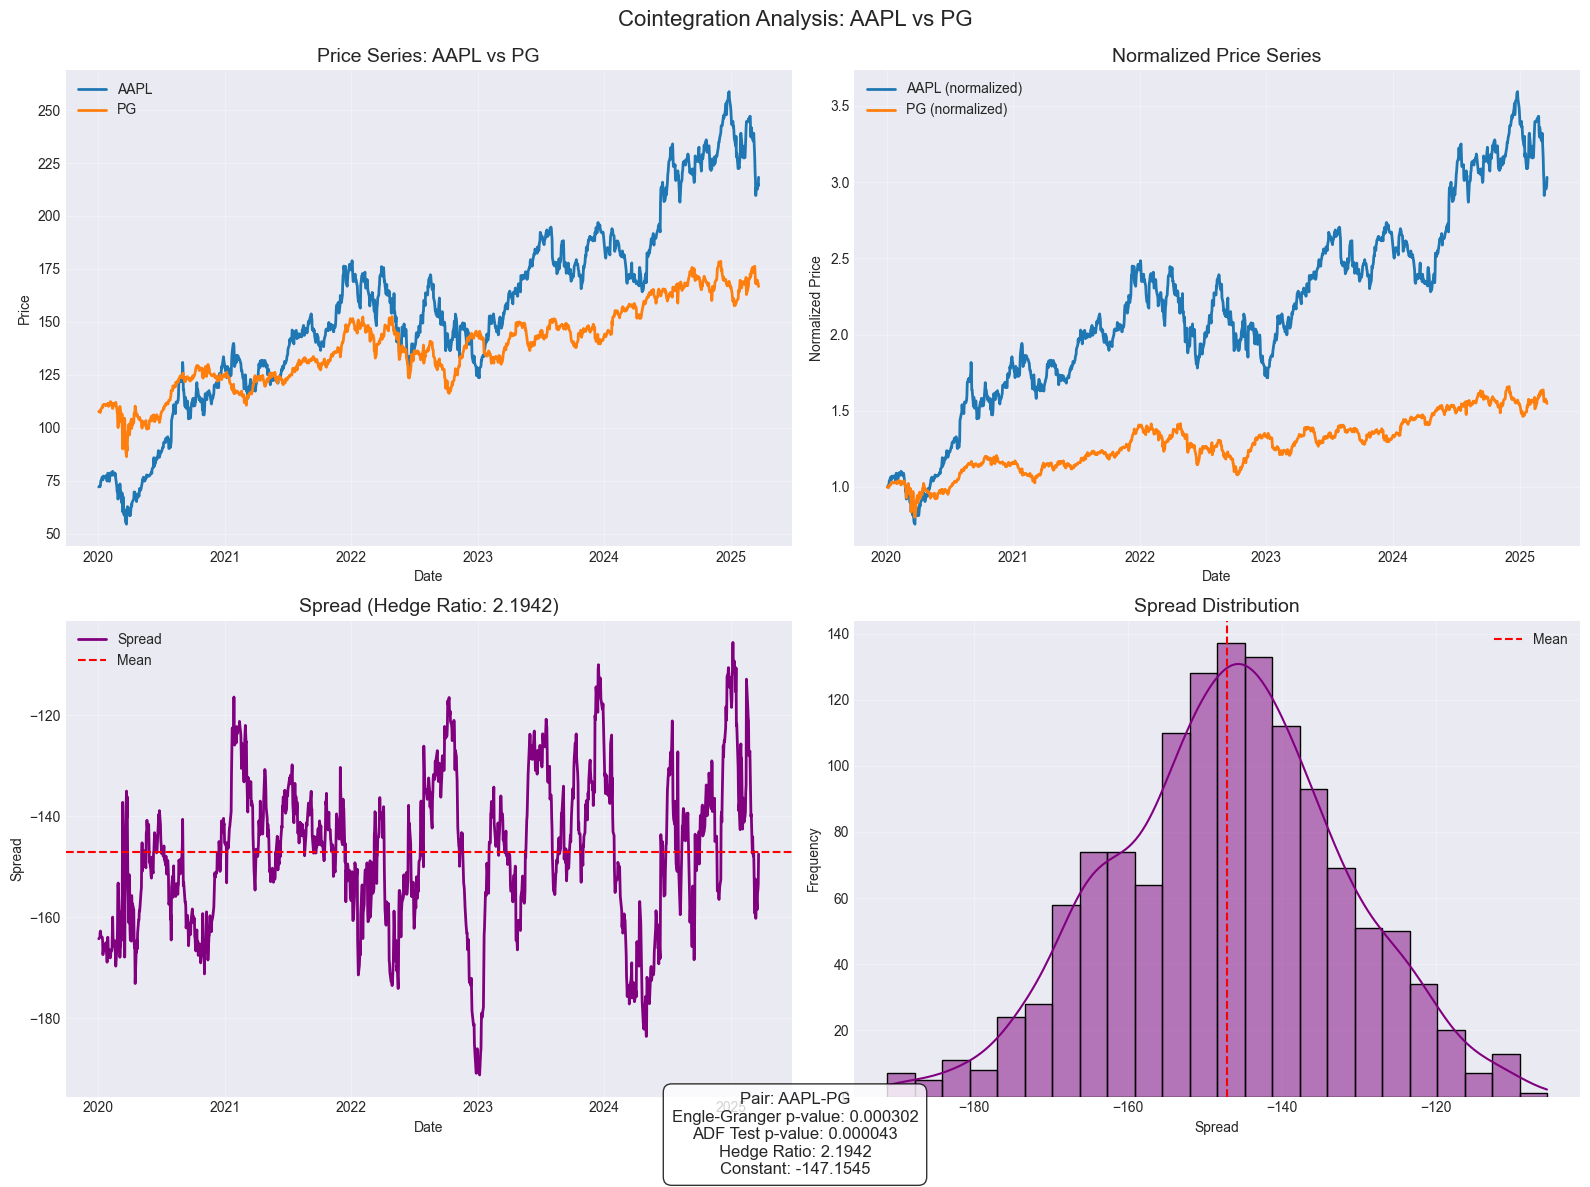

Model parameters: const   -5.117969
0       -0.034867
dtype: float64
Half-life of mean reversion for AAPL-PG: 19.88 days


C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


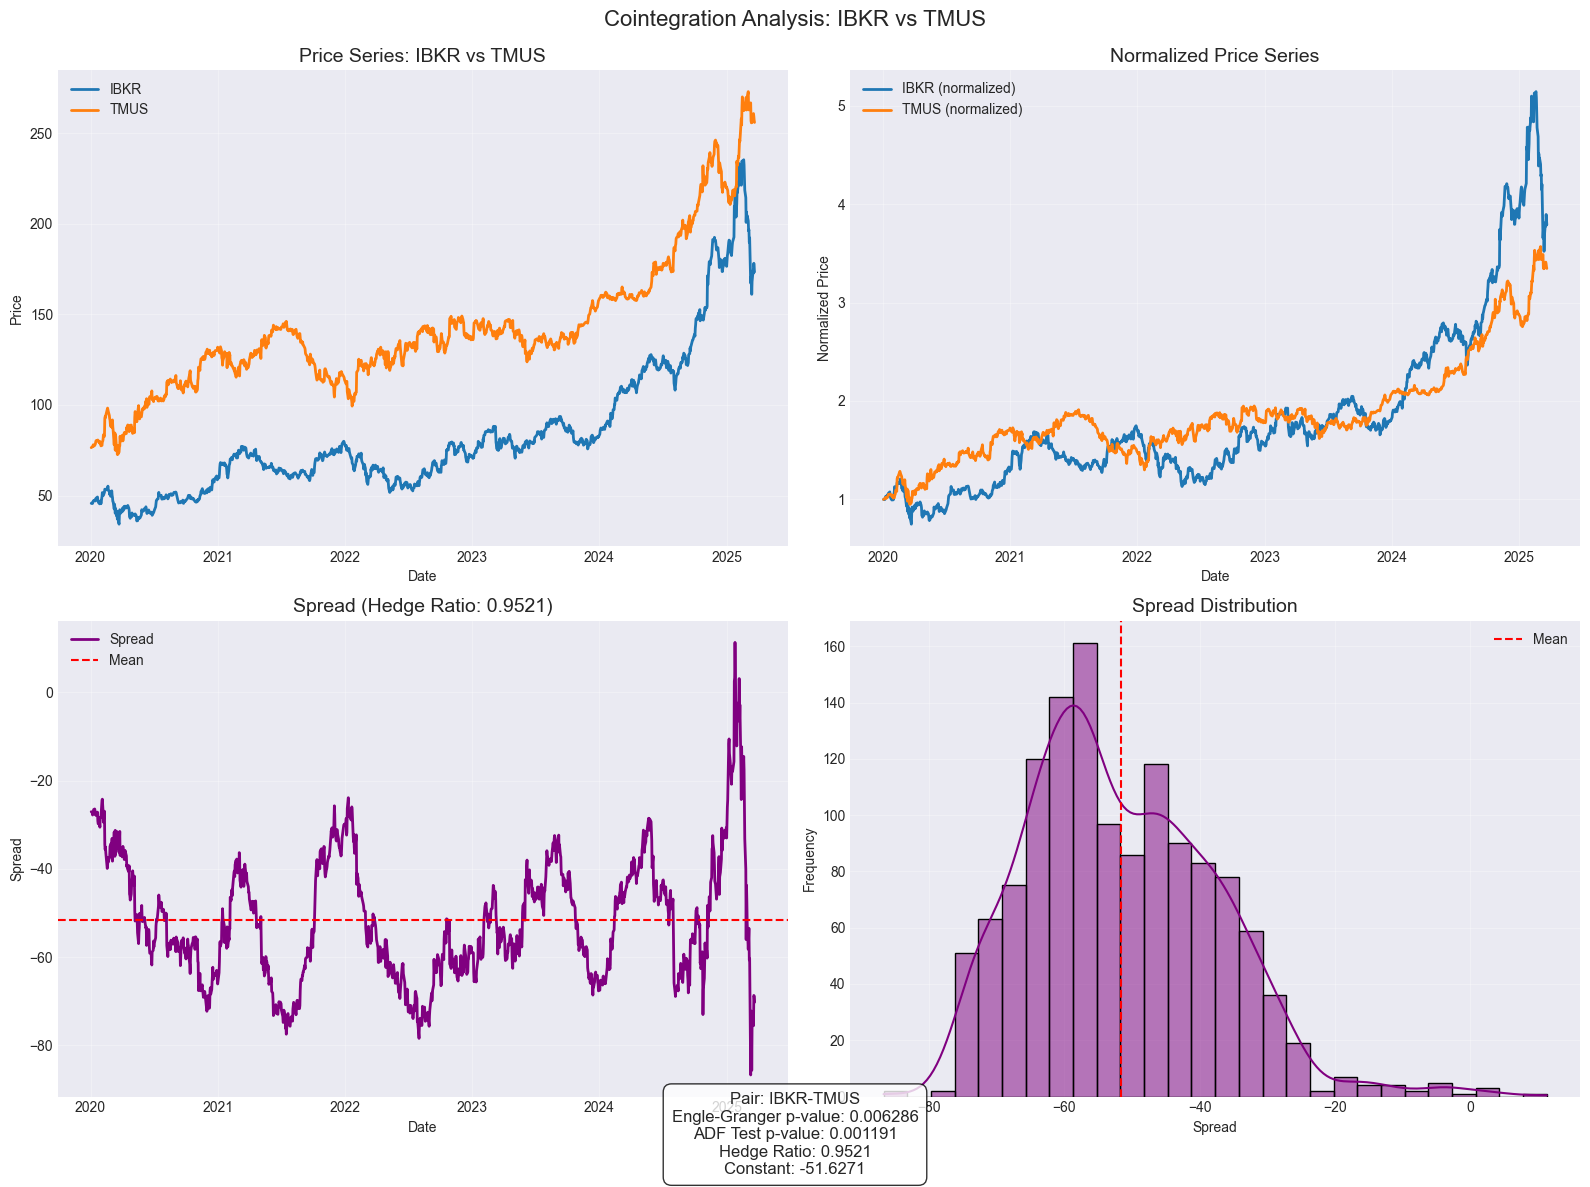

Model parameters: const   -1.026209
0       -0.019244
dtype: float64
Half-life of mean reversion for IBKR-TMUS: 36.02 days


C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


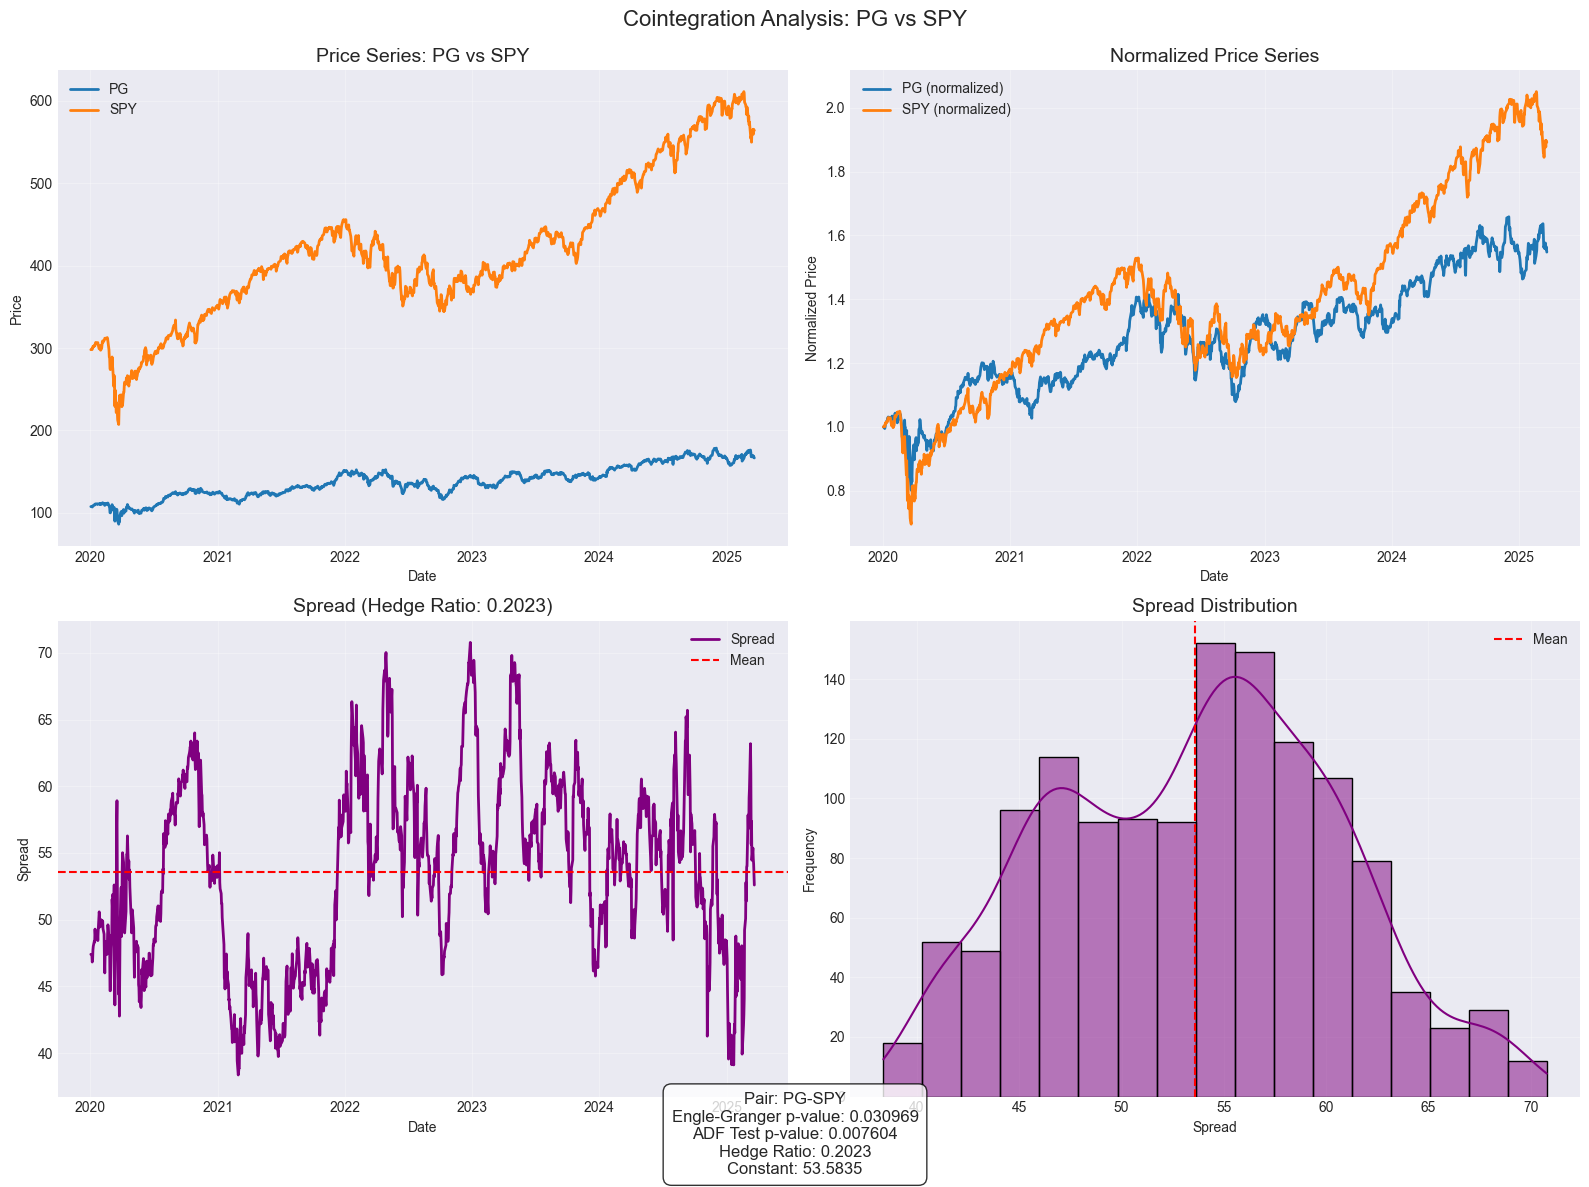

Model parameters: const    1.334734
0       -0.024835
dtype: float64
Half-life of mean reversion for PG-SPY: 27.91 days


C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


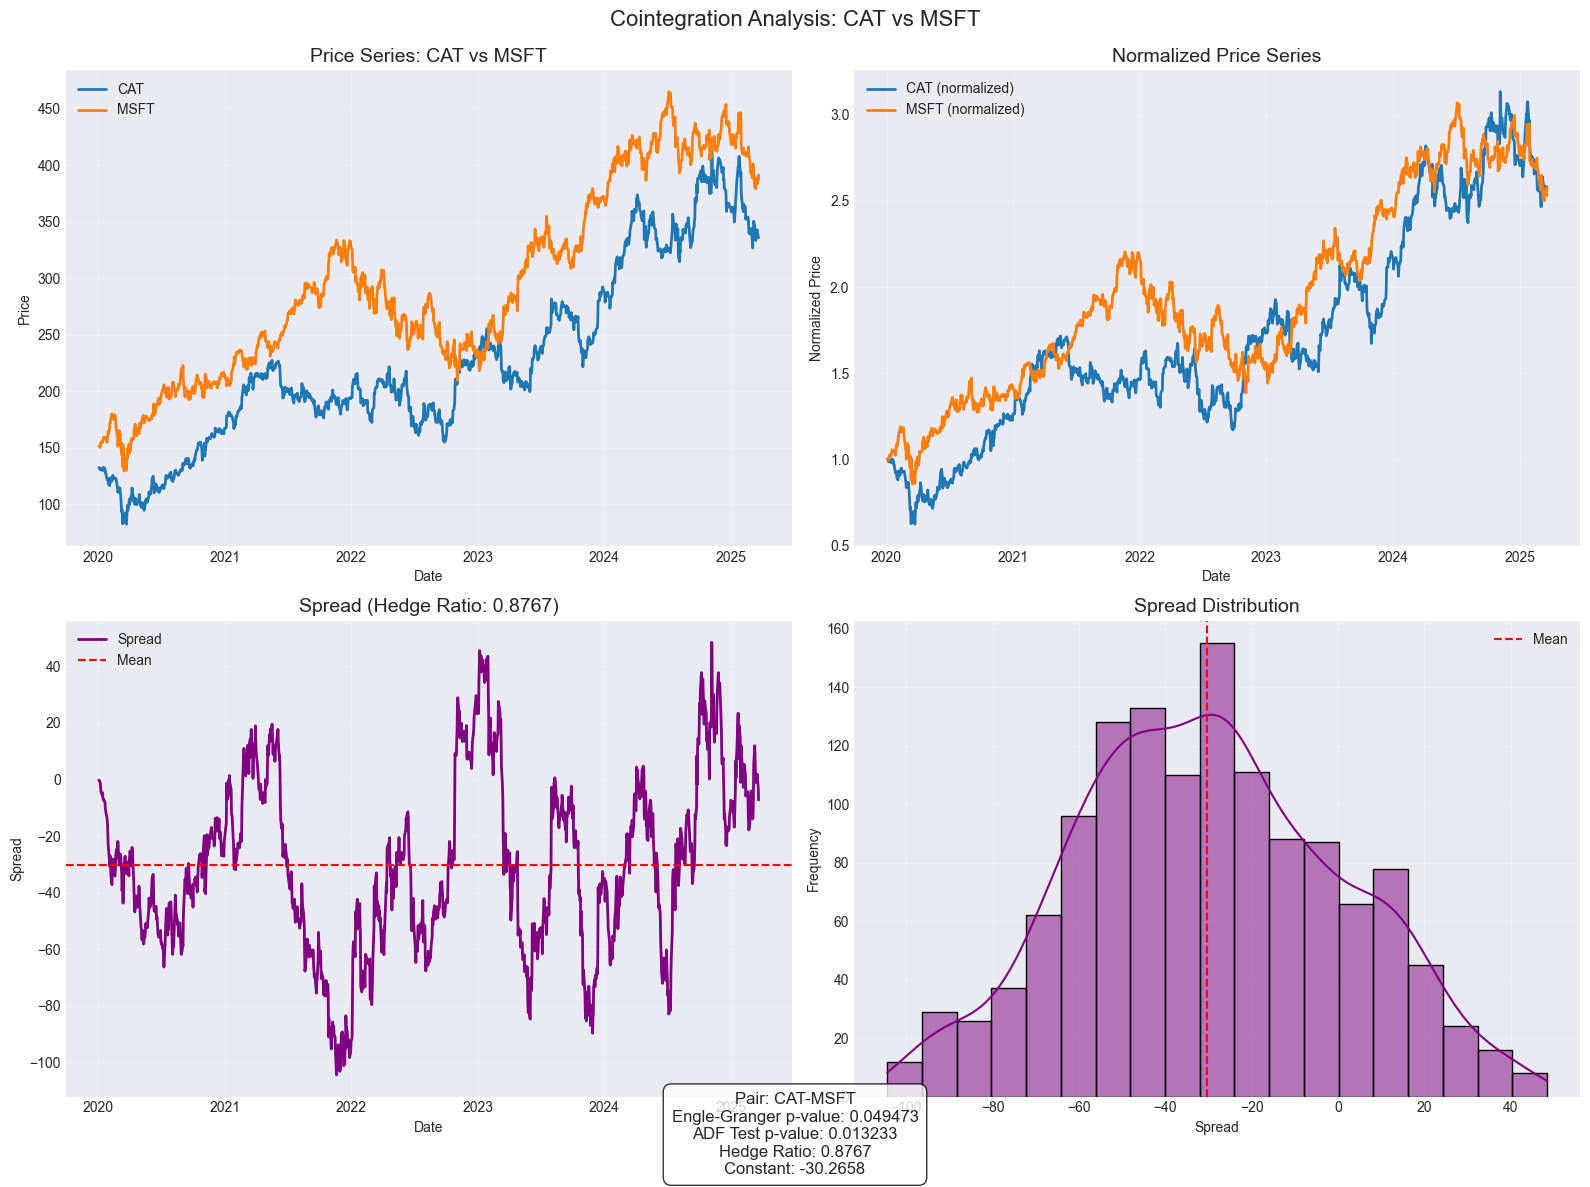

Model parameters: const   -0.444229
0       -0.014492
dtype: float64
Half-life of mean reversion for CAT-MSFT: 47.83 days


C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
C:\Users\aumpa\AppData\Local\Temp\ipykernel_9588\796015570.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[0]


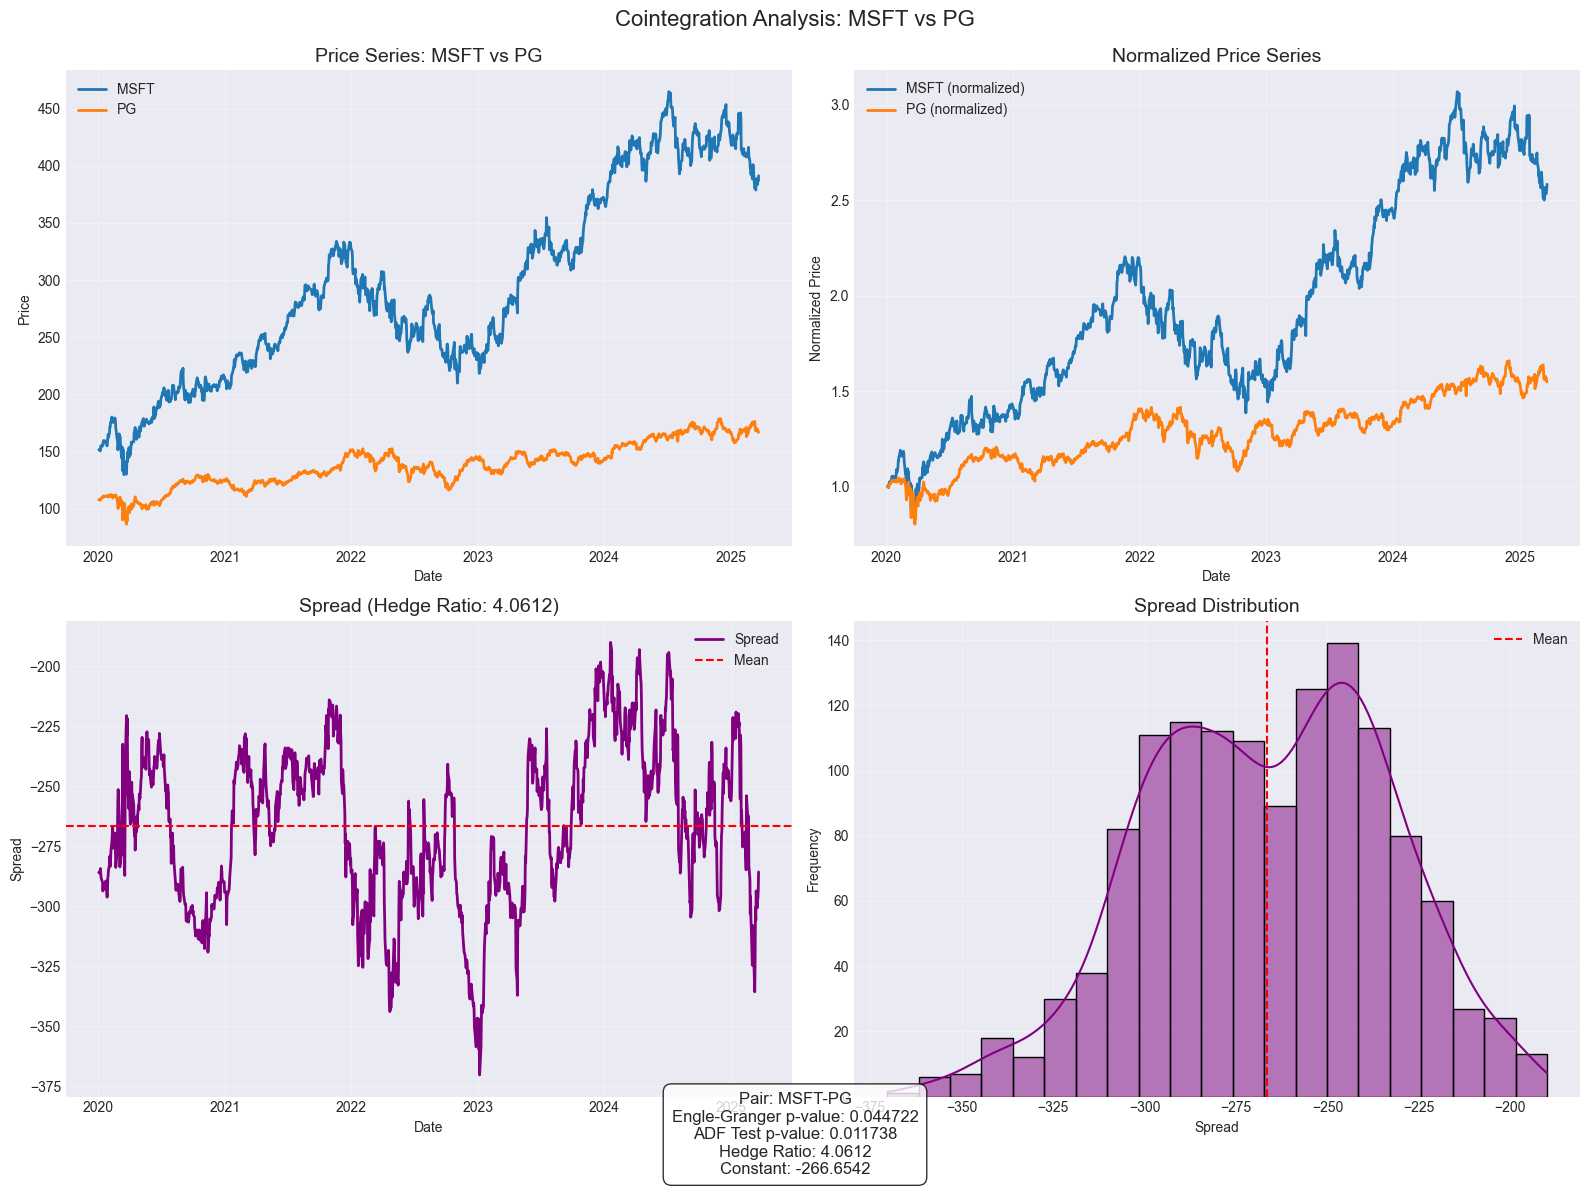

Model parameters: const   -6.309611
0       -0.023664
dtype: float64
Half-life of mean reversion for MSFT-PG: 29.29 days


In [16]:
# 6. Visualize cointegrated pairs
if len(cointegrated_pairs_df) > 0:
    # Take top 5 cointegrated pairs (or fewer if less than 5)
    top_n = min(5, len(cointegrated_pairs_df))
    
    for i in range(top_n):
        row = cointegrated_pairs_df.iloc[i]
        ticker1 = row['Ticker1']
        ticker2 = row['Ticker2']
        p_value = row['PValue']
        
        # Filter data for the two tickers
        pair_data = processed_df[processed_df['Ticker'].isin([ticker1, ticker2])]
        
        # Pivot to get time series
        pivot_df = pair_data.pivot(index='Date', columns='Ticker', values='Adjusted')
        
        # Get price series
        price1 = pivot_df[ticker1]
        price2 = pivot_df[ticker2]
        
        # Calculate hedge ratio (using OLS regression)
        X = sm.add_constant(price2)
        model = sm.OLS(price1, X).fit()
        hedge_ratio = model.params[1]
        alpha = model.params[0]
        
        # Calculate spread
        spread = price1 - hedge_ratio * price2
        
        # Perform ADF test on the spread
        adf_result = adfuller(spread.dropna())
        adf_pvalue = adf_result[1]
        
        # Create a 2x2 subplot
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # Plot 1: Original price series
        ax1.plot(price1.index, price1, label=ticker1, linewidth=2)
        ax1.plot(price2.index, price2, label=ticker2, linewidth=2)
        ax1.set_title(f'Price Series: {ticker1} vs {ticker2}', fontsize=14)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Price')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Normalized price series
        normalized_price1 = price1 / price1.iloc[0]
        normalized_price2 = price2 / price2.iloc[0]
        
        ax2.plot(normalized_price1.index, normalized_price1, label=f'{ticker1} (normalized)', linewidth=2)
        ax2.plot(normalized_price2.index, normalized_price2, label=f'{ticker2} (normalized)', linewidth=2)
        ax2.set_title('Normalized Price Series', fontsize=14)
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Normalized Price')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Spread (price1 - hedge_ratio * price2)
        ax3.plot(spread.index, spread, label='Spread', color='purple', linewidth=2)
        ax3.axhline(y=spread.mean(), color='r', linestyle='--', label='Mean')
        ax3.set_title(f'Spread (Hedge Ratio: {hedge_ratio:.4f})', fontsize=14)
        ax3.set_xlabel('Date')
        ax3.set_ylabel('Spread')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Histogram of spread
        sns.histplot(spread.dropna(), kde=True, ax=ax4, color='purple')
        ax4.axvline(x=spread.mean(), color='r', linestyle='--', label='Mean')
        ax4.set_title('Spread Distribution', fontsize=14)
        ax4.set_xlabel('Spread')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        # Add test results as text
        text = (f"Pair: {ticker1}-{ticker2}\n"
                f"Engle-Granger p-value: {p_value:.6f}\n"
                f"ADF Test p-value: {adf_pvalue:.6f}\n"
                f"Hedge Ratio: {hedge_ratio:.4f}\n"
                f"Constant: {alpha:.4f}")
        
        plt.figtext(0.5, 0.01, text, ha='center', fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.suptitle(f'Cointegration Analysis: {ticker1} vs {ticker2}', fontsize=16)
        plt.subplots_adjust(top=0.93)
        plt.show()

        # Additional analysis: Calculate half-life of mean reversion
        # This measures how quickly the spread reverts to its mean
        spread_lag = spread.shift(1)
        spread_diff = spread - spread_lag
        spread_lag = spread_lag.dropna()
        spread_diff = spread_diff.dropna()
        
        # Regression of spread difference on lagged spread level
        X = sm.add_constant(spread_lag)
        model = sm.OLS(spread_diff, X).fit()
        
        # Calculate half-life (fixed to handle different parameter indexing)
        print(f"Model parameters: {model.params}")
        
        # Handle different parameter indexing methods
        try:
            # Try accessing by name if the model has named parameters
            lambda_param = -model.params['spread_lag']
        except (KeyError, TypeError):
            try:
                # Try accessing by name (if the constant is named 'const' and the other parameter is x1)
                lambda_param = -model.params['x1']
            except (KeyError, TypeError):
                try:
                    # Try accessing by index position directly
                    lambda_param = -model.params.values[1]
                except IndexError:
                    try:
                        # Try using iloc which is more reliable for positional indexing
                        lambda_param = -model.params.iloc[1]
                    except:
                        # Last resort - if there are parameters, use the non-constant one
                        if len(model.params) >= 2:
                            # Get the parameter that's not the constant
                            lambda_param = -model.params[list(model.params.index)[1]]
                        else:
                            lambda_param = 0
                            print(f"Warning: Could not determine lambda parameter for {ticker1}-{ticker2}")
        
        if lambda_param > 0:
            half_life = np.log(2) / lambda_param
            print(f"Half-life of mean reversion for {ticker1}-{ticker2}: {half_life:.2f} days")
        else:
            print(f"Warning: Non-mean reverting process detected for {ticker1}-{ticker2} (lambda = {lambda_param})")


In [17]:
# 7. Save cointegrated pairs for trading signal generation
if len(cointegrated_pairs_df) > 0:
    # Save the cointegration test results
    coint_results_path = cointegration_tester.save_cointegration_results(
        coint_results_df, 
        filename="cointegration_results.csv"
    )
    logger.info(f"Cointegration test results saved to {coint_results_path}")
    
    # Save only the cointegrated pairs
    cointegrated_pairs_path = os.path.join('..', 'data', 'processed', 'cointegrated_pairs.csv')
    cointegrated_pairs_df.to_csv(cointegrated_pairs_path, index=False)
    logger.info(f"Cointegrated pairs saved to {cointegrated_pairs_path}")
    
    print(f"Identified {len(cointegrated_pairs_df)} cointegrated pairs out of {len(coint_results_df)} tested.")
    print(f"Saved cointegrated pairs to {cointegrated_pairs_path} for trading signal generation.")
else:
    print("No cointegrated pairs found. Consider relaxing the significance level or finding other pairs.")


[ 2025-05-11 20:00:41,204 ] 478 src.analysis.cointegration_tests - INFO - Saving cointegration test results to ..\data\processed\cointegration_results.csv
[ 2025-05-11 20:00:41,213 ] 483 src.analysis.cointegration_tests - INFO - Cointegration test results successfully saved to ..\data\processed\cointegration_results.csv
[ 2025-05-11 20:00:41,214 ] 8 cointegration_tests_notebook - INFO - Cointegration test results saved to ..\data\processed\cointegration_results.csv
[ 2025-05-11 20:00:41,219 ] 13 cointegration_tests_notebook - INFO - Cointegrated pairs saved to ..\data\processed\cointegrated_pairs.csv


Identified 11 cointegrated pairs out of 111 tested.
Saved cointegrated pairs to ..\data\processed\cointegrated_pairs.csv for trading signal generation.
